In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/13 23:06:21 WARN Utils: Your hostname, LAPTOP-03OFAS5P resolves to a loopback address: 127.0.1.1; using 172.19.168.222 instead (on interface eth0)
22/09/13 23:06:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/13 23:06:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Read data
sdf = spark.read.parquet("../../data/curated/process_data.parquet/")

In [3]:
sdf.show(1, vertical=True)

-RECORD 0------------------------------
 merchant_abn   | 32709545238          
 consumer_id    | 561                  
 user_id        | 14108                
 dollar_value   | 361.79               
 order_id       | 7f2cbe00-1d8c-49b... 
 order_datetime | 2021-08-21           
 state          | NSW                  
 postcode       | 2293                 
 gender         | Male                 
 merchant_name  | Tempor Est Founda... 
 tag            | stationery, offic... 
 revenue        | c                    
 rate           | 3.04                 
 category       | retail_and_wholes... 
only showing top 1 row



## Plots:

1. category vs dollar value
2. category vs dollar value for each month
3. category vs gender
4. category vs state
5. state vs value

<function matplotlib.pyplot.show(close=None, block=None)>

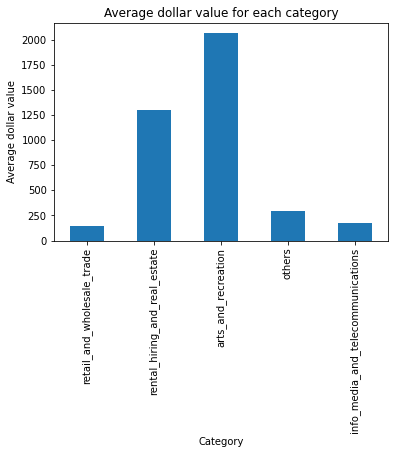

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# calculate average dollar values for each category
valuepd = sdf.groupBy("category").mean("dollar_value").toPandas()

# plot results
ax = valuepd.plot.bar(x = "category", y = "avg(dollar_value)", legend = False)
ax.set_xlabel("Category")
ax.set_ylabel("Average dollar value")
ax.set_title("Average dollar value for each category")
plt.show

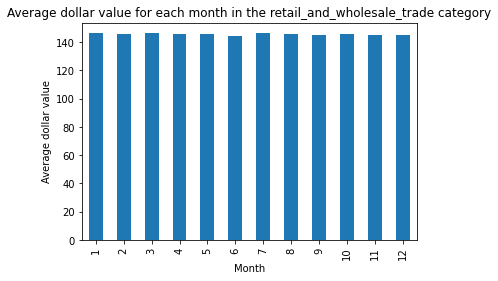

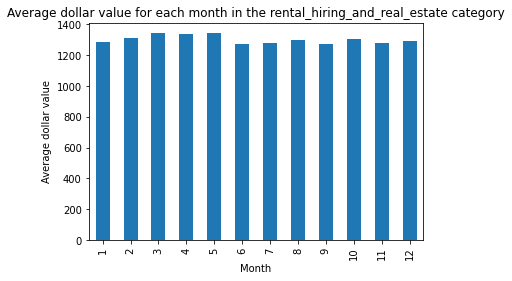

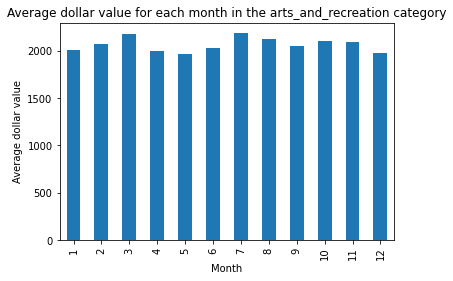

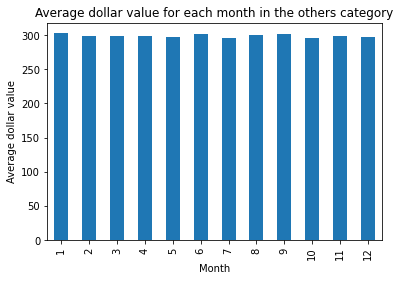

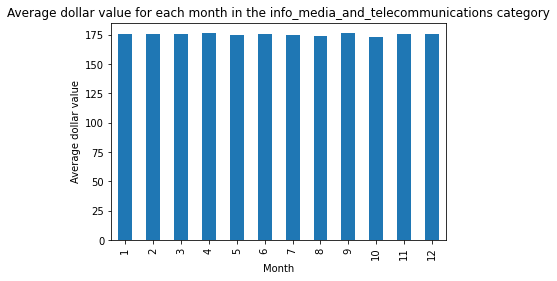

In [56]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import month

# extract month from order_datetime
sdf = sdf.withColumn("month", month(F.col("order_datetime").cast(TimestampType())))

# create a list of the categories
categories = sdf.select("category").distinct().collect()

# draw a plot of distribution of transactions by month for each category
for i in categories:

    # calculate average dollar values for each month
    current_sdf = sdf.filter(F.col("category") == i[0])
    monthpd = current_sdf.groupBy("month").mean("dollar_value").toPandas()
    monthpd = monthpd.sort_values(by = "month")

    # plot results
    ax = monthpd.plot.bar(x = "month", y = "avg(dollar_value)", legend = False)
    ax.set_xlabel("Month")
    ax.set_ylabel("Average dollar value")
    ax.set_title("Average dollar value for each month in the " + i[0] + " category")
    plt.show

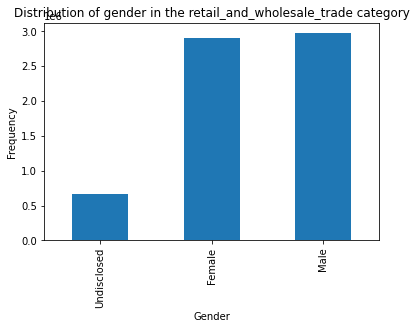

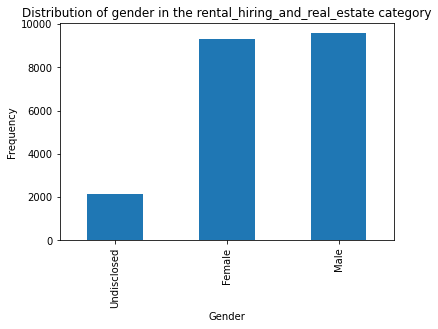

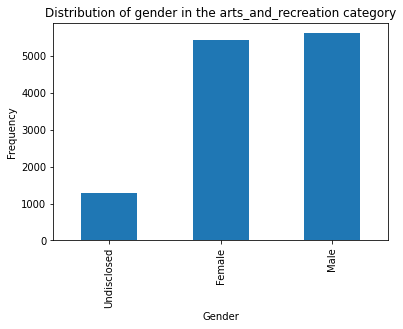

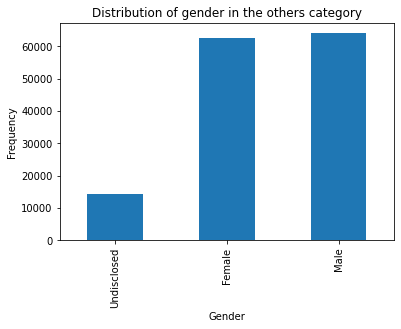

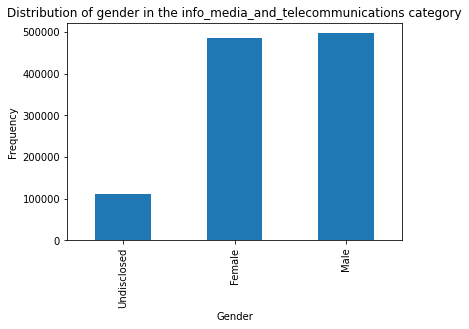

In [57]:
# draw a plot of distribution of transactions by month for each category
for i in categories:

    # calculate number of transactions by gender
    current_sdf = sdf.filter(F.col("category") == i[0])
    genderpd = current_sdf.groupBy("gender").count().toPandas()

    # plot results
    ax = genderpd.plot.bar(x = "gender", y = "count", legend = False)
    ax.set_xlabel("Gender")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of gender in the " + i[0] + " category")
    plt.show

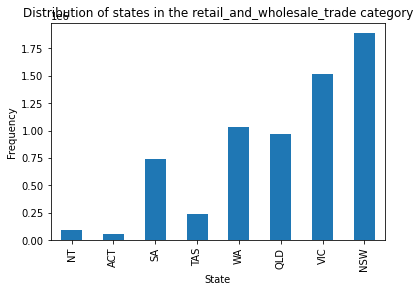

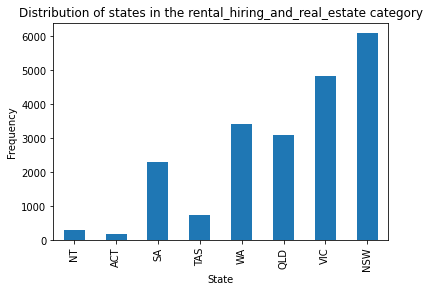

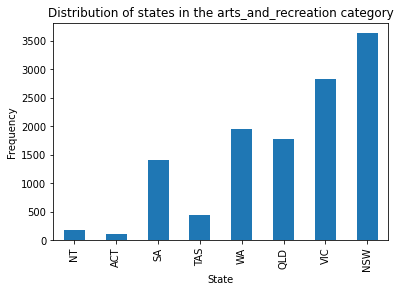

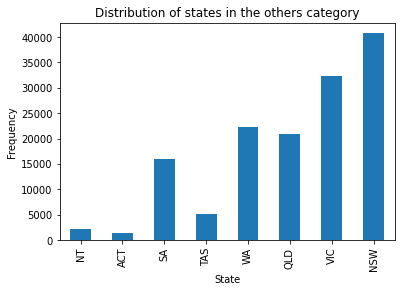

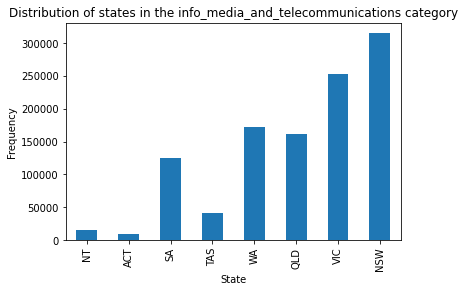

In [58]:
# draw a plot of distribution of transactions by state for each category
for i in categories:

    # calculate number of transactions by state
    current_sdf = sdf.filter(F.col("category") == i[0])
    genderpd = current_sdf.groupBy("state").count().toPandas()

    # plot results
    ax = genderpd.plot.bar(x = "state", y = "count", legend = False)
    ax.set_xlabel("State")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of states in the " + i[0] + " category")
    plt.show

## Null Values:

Check for null/invalid values for the following columns:
1. merchant_abn, consumer_id and user_id should be integers that are greater than 0.
2. Dollar value should be positive (>0)
3. order_id, order_datetime, state, merchant name, tag should not be null.
4. postcode should be between 200 and 9944 inclusive.
5. gender should be "Female", "Male" or "Undisclosed".
6. revenue should be "a", "b", "c", "d" or "e".
7. rate should be between 0 and 100.

In [31]:
initial = sdf.count()

#1
sdf = sdf.filter(F.col('merchant_abn') > 0)
sdf = sdf.filter(F.col('consumer_id') > 0)
sdf = sdf.filter(F.col('user_id') > 0)
count1 = sdf.count()

#2
sdf = sdf.filter(F.col('dollar_value') > 0)
count2 = sdf.count()

#3
sdf = sdf.filter(F.col('order_id').isNotNull())
sdf = sdf.filter(F.col('order_datetime').isNotNull())
sdf = sdf.filter(F.col('state').isNotNull())
sdf = sdf.filter(F.col('merchant_name').isNotNull())
sdf = sdf.filter(F.col('tag').isNotNull())
count3 = sdf.count()

#4
sdf = sdf.filter(F.col('postcode').cast("integer") > 200)
sdf = sdf.filter(F.col('postcode').cast("integer") < 9944)
count4 = sdf.count()

#5
sdf = sdf.filter((F.col("gender") == "Male")|(F.col("gender") == "Female")|(F.col("gender") == "Undisclosed"))
count5 = sdf.count()

#6
sdf = sdf.filter((F.col("revenue") == "a")|(F.col("revenue") == "b")|(F.col("revenue") == "c")|
    (F.col("revenue") == "d")|(F.col("revenue") == "e"))
count6 = sdf.count()

#7
sdf = sdf.withColumn("rate", F.col("rate").cast("double"))
sdf = sdf.filter((F.col("rate") >= 0)&(F.col("rate") <= 100))
count7 = sdf.count()

In [36]:
print("initial count: ", initial)
print("after step 1: ", count1)
print("after step 2: ", count2)
print("after step 3: ", count3)
print("after step 4: ", count4)
print("after step 5: ", count5)
print("after step 6: ", count6)
print("after step 7: ", count7)
print("total NULL/invalid instances: ", initial-count7)

initial count:  3643266
after step 1:  3643266
after step 2:  3643129
after step 3:  3493902
after step 4:  3492711
after step 5:  3492711
after step 6:  3492711
after step 7:  3492711
total NULL/invalid instances:  150555


The result shows that some instances are removed in steps 2, 3 and 4. There are 150555 null/invalid values in total. Since the number of invalid/null instances is small compared to the size of the entire dataset (around 4.3% of the entire dataset), we can simply remove them without imputations.

## Missing Values:

Check for missing values:

In [40]:
print(sdf.filter(F.col('order_id') == "").count())
print(sdf.filter(F.col('order_datetime') == "").count())
print(sdf.filter(F.col('state') == "").count())
print(sdf.filter(F.col('merchant_name') == "").count())
print(sdf.filter(F.col('tag') == "").count())

0
0
0
0
0


There are no missing values.

## Outliers

Check for outliers in the dollar_value.

In [41]:
sdf.describe("dollar_value")

summary,dollar_value
count,3492711
mean,158.6165965177199
stddev,467.7023897547347
min,0.01
max,105193.89


We can consider dollar values that are outside the range (mean-3\*stddev, mean+3\*stddev) as outliers.

In [43]:
print(sdf.filter(F.col('dollar_value') > (158.6165965177199 + 3 * 467.7023897547347)).count())

32094


There are 32094 outliers, which is not a significant amount. We can remove these instances.

Plot the distribution of the dollar_value before and after removal of the outliers.

In [44]:
# set bin size
binsize = 100
dict = {}

# count number of instances for each bin
for i in range(1,16):
    count = sdf.filter(((i-1)*binsize < F.col('dollar_value')) & (F.col('dollar_value') <= i*binsize)).count()
    dict[str((i-1)*binsize)+"-"+str(i*binsize)] = count

# count number of instances for the remaining bin
sumval = sum(dict.values())
dict['>1500'] = sdf.count() - sumval

<function matplotlib.pyplot.show(close=None, block=None)>

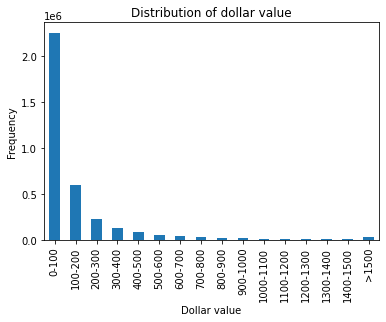

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# plot the graph and add labels and a title
fig, ax = plt.subplots()
ax = pd.Series(dict).plot.bar()
ax.set_xlabel("Dollar value")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of dollar value")

# show plot
plt.show

In [46]:
#Remove outliers
sdf = sdf.filter(F.col('dollar_value') <= (158.6165965177199 + 3 * 467.7023897547347))

In [47]:
# set bin size
binsize = 100
dict = {}

# count number of instances for each bin
for i in range(1,16):
    count = sdf.filter(((i-1)*binsize < F.col('dollar_value')) & (F.col('dollar_value') <= i*binsize)).count()
    dict[str((i-1)*binsize)+"-"+str(i*binsize)] = count

# count number of instances for the remaining bin
sumval = sum(dict.values())
dict['>1500'] = sdf.count() - sumval

<function matplotlib.pyplot.show(close=None, block=None)>

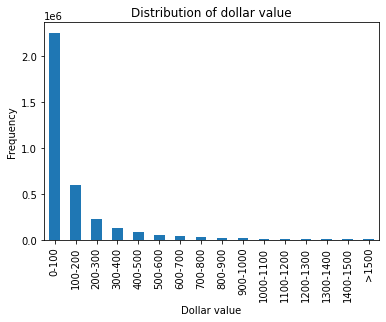

In [48]:
# plot the graph and add labels and a title
fig, ax = plt.subplots()
ax = pd.Series(dict).plot.bar()
ax.set_xlabel("Dollar value")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of dollar value")

# show plot
plt.show

It can be seen that the distribution of dollar_value does not change at all other than the extremely large values.